In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# K Means Cluster - Neural Network Embeddings
Cluster the NAICS embeddings from the Neural Network.  Compare this clustering to the default NAICS code clusters on these embeddings

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from sklearn.preprocessing import OneHotEncoder

In [4]:
from pathlib import Path

In [5]:
import sklearn as sk
from sklearn.cluster import KMeans

In [6]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

In [7]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import importlib

In [8]:
from sba_gnn.sba_gnn import sg_plot, sg_embed

In [9]:
sg_plot.plot_defaults()

## Import Data

##### Embeddings

In [10]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('12_DATA_embeddings.parquet')) 

In [11]:
emb_feat = [c for c in embed_df.columns if c.startswith('emb_')]

##### Loans data - get one hot length

In [12]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [13]:
one_hot_feat= [c for c in sba_loans.columns if c.startswith('NS__')]
one_hot_feat_len = len(one_hot_feat)
one_hot_feat_len

9

## NAICS mappings
Import the map, and flag the ones selected by OneHotEncoder in script 01.  Also add in train counts, standard mean encodings, and raw means

In [14]:
naics_map = pd.read_csv('naics/naics_map.csv', dtype='str', encoding='latin1' ) \
    .rename(columns={'Sector': 'NAICS_sector',
                     'Description': 'NAICS_sector_desc'})

In [15]:
one_hot_cat = [c.split('___')[-1] for c in one_hot_feat]
one_hot_cat

['Accommodation and Food Services',
 'Construction',
 'Health Care and Social Assistance',
 'Manufacturing',
 'Other Services (except Public Administration)',
 'Professional, Scientific, and Technical Services',
 'Retail Trade',
 'Wholesale Trade',
 'infrequent_sklearn']

In [16]:
naics_map['NAICS_sector_sel'] = np.where(naics_map['NAICS_sector_desc'].isin(one_hot_cat), 1, 0)
naics_map.drop_duplicates('NAICS_sector')['NAICS_sector_sel'].value_counts()
naics_map['NAICS_sector_comb'] = naics_map['NAICS_sector'] + ':' + naics_map['NAICS_sector_desc'].str[0:20]

In [17]:
naics_map.head(5)

,NAICS_sector,NAICS_2,NAICS_sector_desc,NAICS_sector_sel,NAICS_sector_comb
0,11,11,"Agriculture, Forestry, Fishing and Hunting",0,"11:Agriculture, Forestr"
1,21,21,"Mining, Quarrying, and Oil and Gas Extraction",0,"21:Mining, Quarrying, a"
2,22,22,Utilities,0,22:Utilities
3,23,23,Construction,1,23:Construction
4,31-33,31,Manufacturing,1,31-33:Manufacturing


In [18]:
naics_map.to_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_map.parquet')) 

##### Get NAICS info
Include train data count and rates, as well as mean and count encodings

In [19]:
naics_info_1 = sba_loans[sba_loans['dset'] == 'train'] \
    .groupby('NAICS') \
    ['target'] \
    .agg(['count', 'mean']) \
    .set_axis(['train_count', 'train_target_mean'], axis=1) \
    .reset_index()

In [20]:
naics_info_2 = sba_loans\
    .groupby('NAICS') \
    [['NAICS_sector', 'menc_NAICS', 'cenc_NAICS', 'dset_naics_holdout']] \
    .agg('first') \
    .reset_index()

In [21]:
naics_info_3 = sba_loans \
    .groupby('NAICS') \
    ['target'] \
    .agg(['count', 'mean']) \
    .set_axis(['all_count', 'all_target_mean'], axis=1) \
    .reset_index()

In [22]:
naics_info = naics_info_1.merge(naics_info_2, on='NAICS', how='right') \
    .merge(naics_info_3, on='NAICS', how='right') \
    .merge(naics_map[['NAICS_sector', 'NAICS_sector_sel']].drop_duplicates('NAICS_sector'), on='NAICS_sector', how='left')
naics_info['train_count'] = naics_info['train_count'].fillna(0)

In [23]:
naics_info.sample(3)

,NAICS,train_count,train_target_mean,NAICS_sector,menc_NAICS,cenc_NAICS,dset_naics_holdout,all_count,all_target_mean,NAICS_sector_sel
370,327111,14.0,0.214286,31-33,0.288867,0.000033,0,28,0.214286,1
570,336111,30.0,0.166667,31-33,0.174997,0.000070,0,52,0.192308,1
383,327310,15.0,0.200000,31-33,0.228614,0.000035,0,24,0.166667,1


In [24]:
naics_info.shape

(1311, 10)

In [25]:
naics_info.to_parquet(Path(setup.temp_path).joinpath('60_DATA_naics_summary_stats.parquet')) 

## Get TSNE Values

In [26]:
tsne_df = pd.concat([sg_embed.emb_tsne_transform(embed_df[emb_feat]), embed_df['NAICS_orig']], axis=1)

## NAICS Sector "Clusters"
Get the silhouette score for the base naics

In [27]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [28]:
embed_df['NAICS_2'] = embed_df['NAICS_orig'].str[0:2]
embed_df = embed_df.drop(columns=['NAICS_sector', 'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb'], 
                         errors='ignore') \
    .merge(naics_map[['NAICS_2', 'NAICS_sector', 'NAICS_sector_sel', 'NAICS_sector_desc', 'NAICS_sector_comb']], how='left')

In [29]:
embed_df['NAICS_sector_comb'] = embed_df['NAICS_sector_comb'].astype('category')

In [30]:
embed_df.shape

(1311, 15)

In [31]:
naics_silhouette = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_comb'])
naics_silhouette_values = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_comb'])

In [32]:
naics_silhouette

-0.16382699

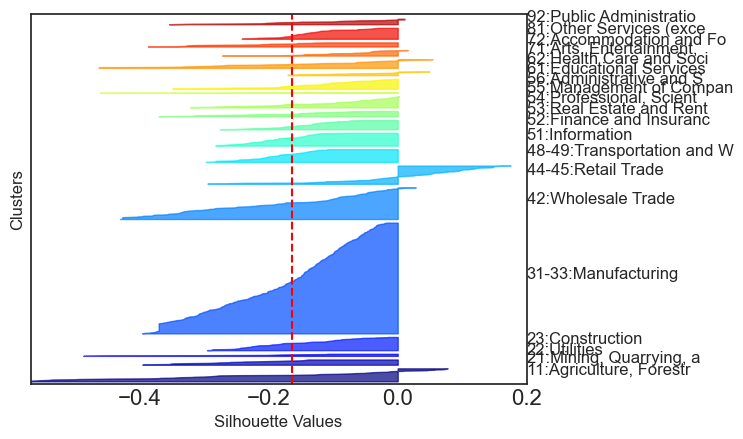

In [33]:
sg_embed.plot_silhouette(naics_silhouette_values, embed_df['NAICS_sector_comb'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_silhouette_base_naics_all.png'),
                 bbox_inches='tight') 

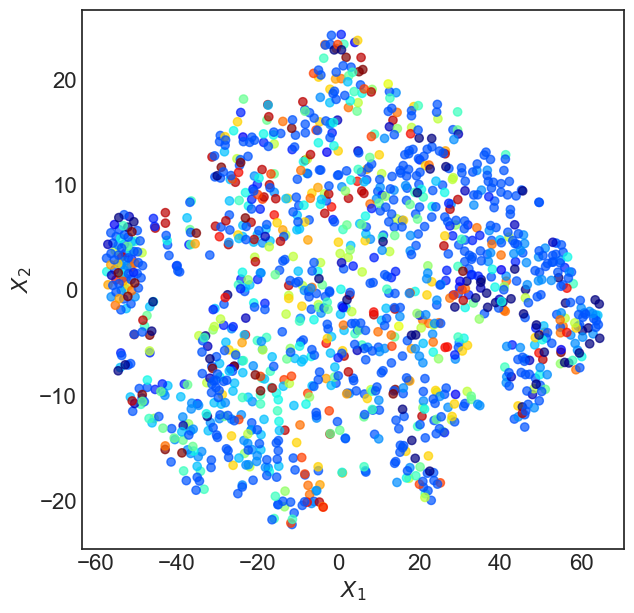

In [34]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector_comb'].cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_all.png'),
                 bbox_inches='tight') 

## NAICS Sectors - Used in One Hot Only
Get the silhouette scores for the NAICS groups used in the one hot encoder (top 8 levels plus "other")

In [35]:
embed_df['NAICS_sector_filt'] = np.where(embed_df['NAICS_sector_sel'] == 0, 'Other',
                                         embed_df['NAICS_sector_comb'])

In [36]:
embed_df.head(3)

,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,NAICS,NAICS_orig,NAICS_2,NAICS_sector,NAICS_sector_sel,NAICS_sector_desc,NAICS_sector_comb,NAICS_sector_filt
0,-0.393896,-0.582756,0.757087,-0.512120,0.468502,0.447364,-0.601314,0.495141,1159.0,722410,72,72,1,Accommodation and Food Services,72:Accommodation and Fo,72:Accommodation and Fo
1,-0.004138,0.047086,0.012811,-0.007829,0.043399,-0.032906,0.046600,0.048037,0.0,445299,44,44-45,1,Retail Trade,44-45:Retail Trade,44-45:Retail Trade
2,-0.004138,0.047086,0.012811,-0.007829,0.043399,-0.032906,0.046600,0.048037,0.0,512110,51,51,0,Information,51:Information,Other


In [37]:
naics_silhouette_sel = silhouette_score(embed_df[emb_feat], embed_df['NAICS_sector_filt'])
naics_silhouette_values_sel = silhouette_samples(embed_df[emb_feat], embed_df['NAICS_sector_filt'])

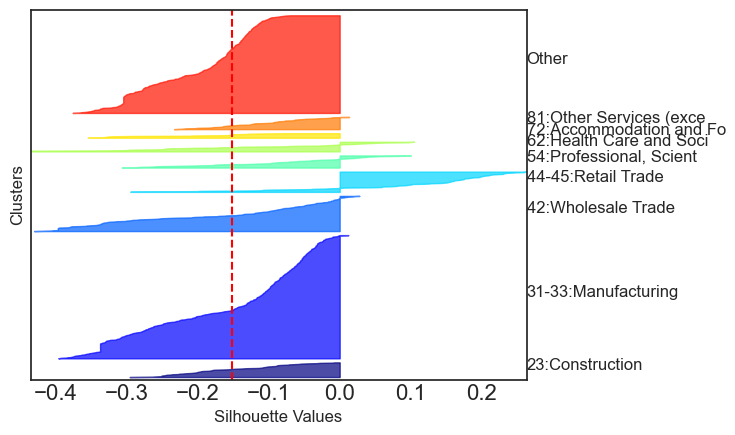

In [38]:
sg_embed.plot_silhouette(naics_silhouette_values_sel, embed_df['NAICS_sector_filt'].to_numpy(),
                        label_x_pos = 1, cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_silhouette_base_naics_sel.png'),
                 bbox_inches='tight') 

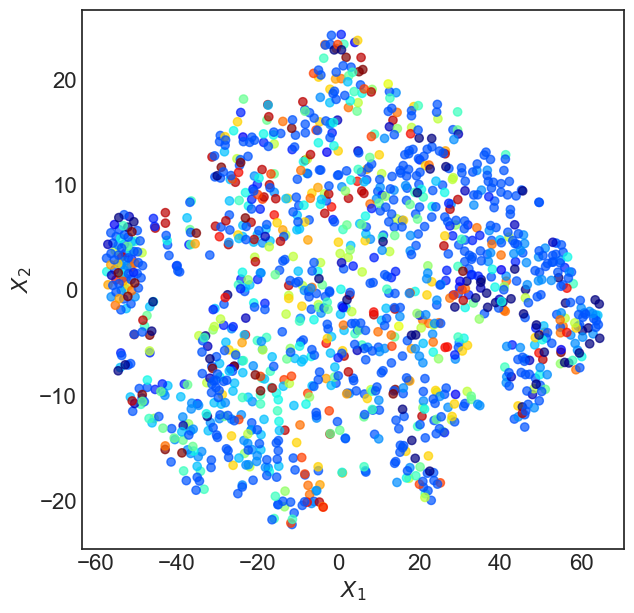

In [39]:
sg_embed.plot_clusters(tsne_df, embed_df['NAICS_sector'].astype('category').cat.codes,
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_base_naics_sel.png'),
                 bbox_inches='tight') 

##### Save the silhouette scores

In [40]:
naics_silhouette_df = pd.DataFrame({'type':['all', 'sel'], 
                                    'score':[naics_silhouette, naics_silhouette_sel]})
naics_silhouette_df.to_csv(Path(setup.temp_path).joinpath('60_REPORT_naics_silhouette_mean.csv'))
naics_silhouette_df

,type,score
0,all,-0.163827
1,sel,-0.152207


## TSNE Plots By Target Rate

In [41]:
tsne_df.head()

,0,1,NAICS_orig
0,-1.795367,7.919950,722410
1,-52.563213,-1.736972,445299
2,-52.813808,0.151942,512110
3,-48.639198,3.570503,541810
4,33.388714,8.092406,421310


In [42]:
tsne_count_df = tsne_df.merge(naics_info.rename(columns={'NAICS':'NAICS_orig'}) \
                                [['NAICS_orig', 'all_target_mean', 'menc_NAICS']],
                              how='left', on='NAICS_orig')

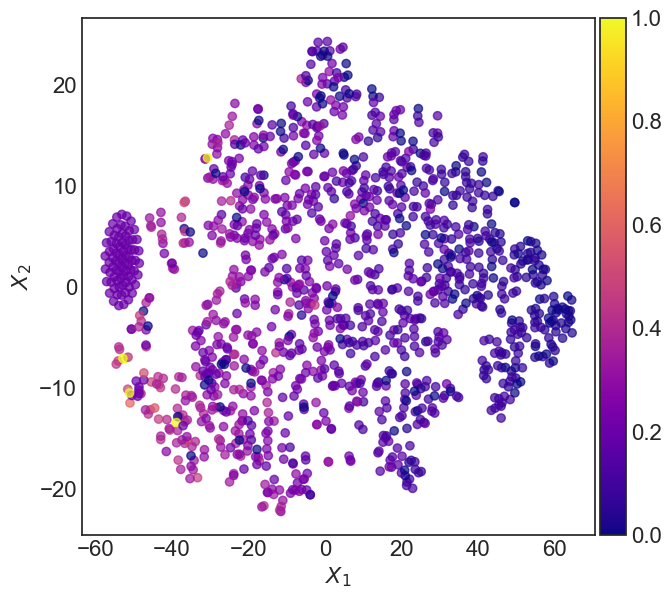

In [43]:
sg_embed.plot_clusters(tsne_count_df, tsne_count_df['menc_NAICS'],
                      center_label=False, cmap=plt.get_cmap('plasma'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_menc.png'),
                bbox_inches='tight') 

In [44]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

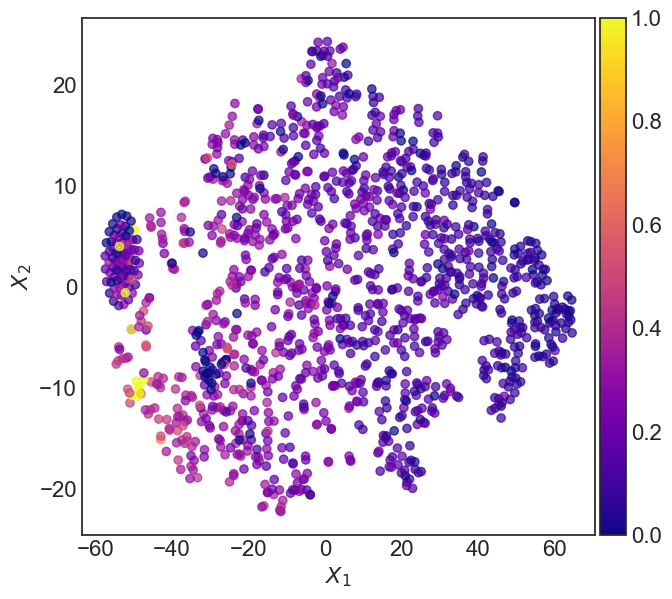

In [45]:
sg_embed.plot_clusters(tsne_count_df, tsne_count_df['all_target_mean'],
                      center_label=False, cmap=plt.get_cmap('plasma'), colorbar = True)
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_tsne_naics_mean.png'),
                 bbox_inches='tight') 

## K Means Loop
Get silhouette scores and cluster info for a variety of counts.  Plot the best score, as well as the selected size

In [46]:
range_n_clusters = np.arange(2, 25)

In [47]:
all_silhouette_summary = pd.DataFrame()
all_cluster_labels = pd.DataFrame()
all_cluster_centers = pd.DataFrame()
all_silhouette_values = pd.DataFrame()

for n_clusters in range_n_clusters:
    
    # Get the kmeans information
    cluster_labels, cluster_centers, silhouette_avg, sample_silhouette_values = \
        sg_embed.get_clusters_silhouettes(embed_df[emb_feat], n_clusters)
        
    # Save silhouette summary
    all_silhouette_summary = pd.concat([all_silhouette_summary, 
                                        pd.DataFrame({'n_clusters': [n_clusters],
                                                      'silhouette_avg':[silhouette_avg]})])
    
    # Save silhouette values
    sample_silhouette_df = pd.DataFrame(sample_silhouette_values, columns=['value'],
                                       index = embed_df.index)
    sample_silhouette_df['n_clusters'] = n_clusters
    sample_silhouette_df.set_index('n_clusters', append=True,  inplace=True)
    all_silhouette_values = pd.concat([all_silhouette_values, sample_silhouette_df])
    
    # Save cluster labels
    cluster_df = pd.DataFrame(cluster_labels, columns=['label'], index=embed_df.index)
    cluster_df['n_clusters'] = n_clusters
    cluster_df.set_index('n_clusters', append=True,  inplace=True)
    all_cluster_labels = pd.concat([all_cluster_labels, cluster_df])
    
    # Save cluster centers
    cluster_centers_df = pd.DataFrame(cluster_centers)
    cluster_centers_df['n_clusters'] = n_clusters
    cluster_centers_df.set_index('n_clusters', append=True, inplace=True)
    all_cluster_centers = pd.concat([all_cluster_centers, cluster_centers_df])

In [48]:
all_silhouette_values.reset_index(level=1, inplace=True)
all_cluster_labels.reset_index(level=1, inplace=True)
all_cluster_centers.reset_index(level=1, inplace=True)

In [49]:
all_silhouette_values.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_silhouette_values.parquet'))
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('60_DATA_loop_silhouette_summary.csv'))

In [50]:
all_cluster_labels.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_cluster_labels.parquet'))

In [51]:
all_cluster_centers.columns = [str(c) for c in all_cluster_centers.columns]
all_cluster_centers.to_parquet(Path(setup.temp_path).joinpath('60_DATA_loop_cluster_centers.parquet'))

##### Get the clusters with the best silhouette score

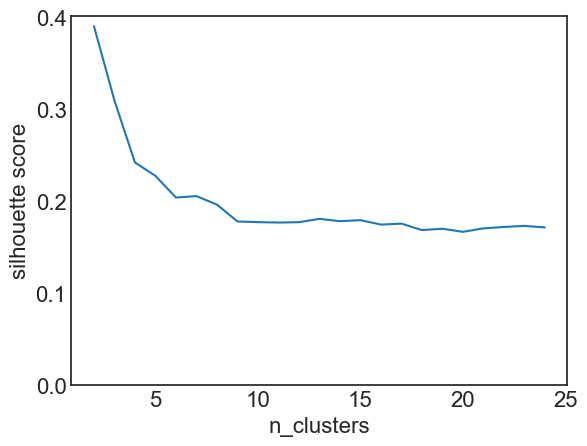

In [52]:
all_silhouette_summary.plot(x='n_clusters', y='silhouette_avg', legend=None)
plt.ylim(bottom=0)
plt.ylabel('silhouette score')
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_summary.png'),
                 bbox_inches='tight') 
all_silhouette_summary.to_csv(Path(setup.temp_path).joinpath('60_REPORT_loop_silhouette_summary.csv'))

In [53]:
best_clus = all_silhouette_summary.sort_values('silhouette_avg', ascending=False)['n_clusters'].iloc[0]
best_clus

2

## Plots for Best Score Clusters

In [54]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [55]:
best_values = all_silhouette_values[all_silhouette_values['n_clusters'] == best_clus] \
    .drop(columns='n_clusters')
best_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == best_clus] \
     .drop(columns='n_clusters')  

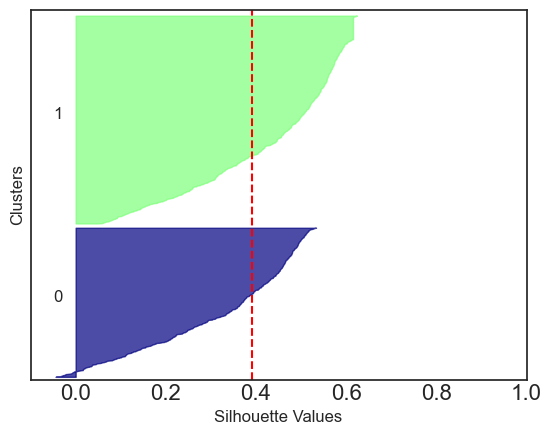

In [56]:
sg_embed.plot_silhouette(best_values.to_numpy(), best_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_best.png'),
                 bbox_inches='tight') 

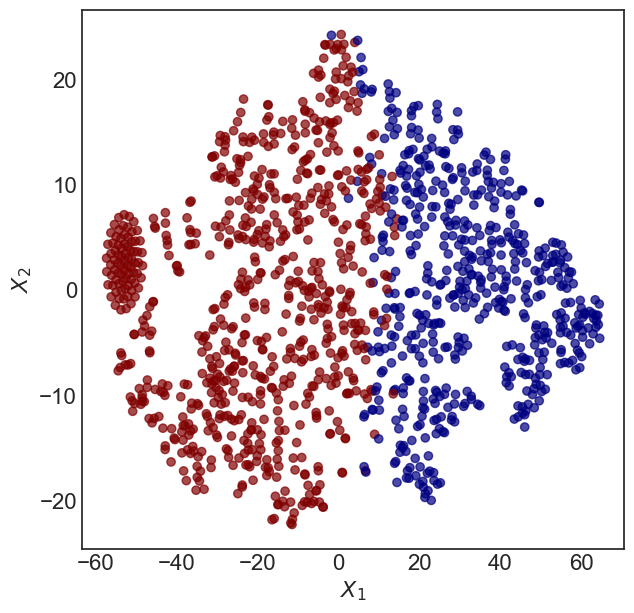

In [57]:
sg_embed.plot_clusters(tsne_df, best_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_clusters_best.png'),
                 bbox_inches='tight') 

## Plots for Selected Length
Use the same number of levels as we have from the original one hot encoding

In [58]:
importlib.reload(sg_embed)

<module 'sba_gnn.sba_gnn.sg_embed' from '/Users/valeriecarey/Documents/projects/2023_10_blog_gnn_sba/code/sba_gnn/sba_gnn/sg_embed.py'>

In [59]:
sel_values = all_silhouette_values[all_silhouette_values['n_clusters'] == one_hot_feat_len] \
    .drop(columns='n_clusters')
sel_labels= all_cluster_labels[all_cluster_labels['n_clusters'] == one_hot_feat_len] \
     .drop(columns='n_clusters')  

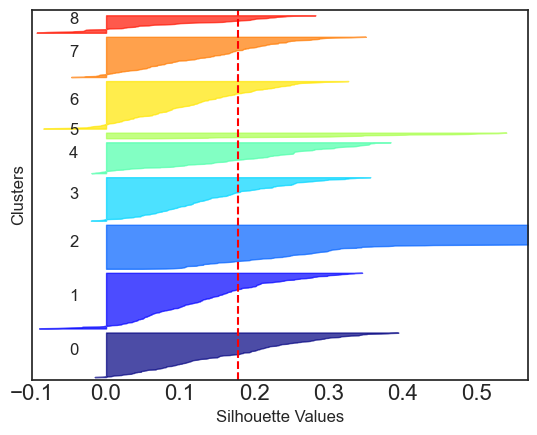

In [60]:
sg_embed.plot_silhouette(sel_values.to_numpy(), sel_labels.to_numpy(),
                        cmap = plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_silhouette_selected.png'),
                 bbox_inches='tight') 

In [61]:
np.max(sel_values.to_numpy())

0.5697059

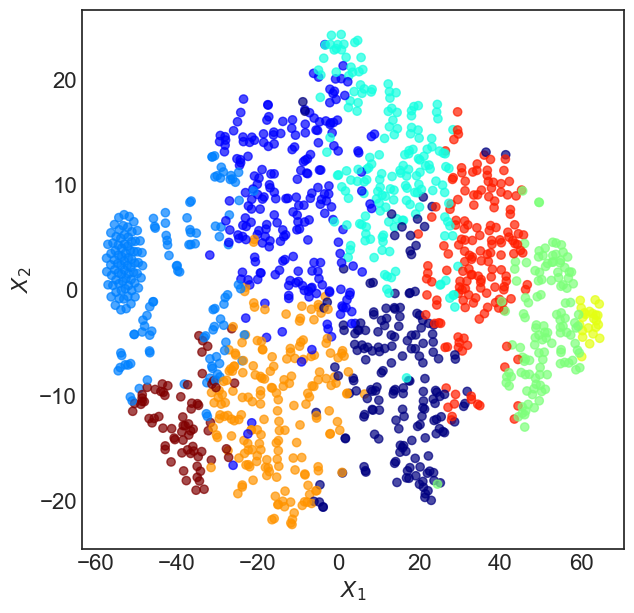

In [62]:
sg_embed.plot_clusters(tsne_df, sel_labels['label'],
                      center_label=False, cmap=plt.get_cmap('jet'))
plt.gcf().savefig(Path(setup.temp_path).joinpath('60_PLOT_loop_clusters_selected.png'),
                 bbox_inches='tight') 

## Save the embeddings with TSNE and Cluster Info
Include one hot encodings

In [63]:
embed_fin_df = pd.concat([embed_df.drop(columns=['tsne_0', 'tsne_1', 'NAICS_orig', 'cluster'], errors='ignore'),
                      tsne_df.rename(columns={0:'tsne_0', 1:'tsne_1'}),
                     sel_labels.rename(columns={'label':'cluster'})], axis=1)

In [64]:
embed_fin_df = pd.concat([embed_fin_df, 
                           pd.get_dummies(embed_fin_df['cluster'],prefix='NC_', dtype='int')],
                         axis=1)

In [65]:
embed_fin_df.to_parquet(Path(setup.temp_path).joinpath('60_DATA_embeddings_tsne_naics.parquet'))